# KiHealth Data Exploration (M1)

Load **unified** KiHealth dataset (TIER 1 + TIER 2), explore distributions by dataset and diabetes status, correlation matrix, missing data heatmap, and validate HOMA.

**BMI** is from all datasets: Frankfurt/DiaBD from source; NHANES from BMX (BMXBMI). Missing BMI ~1.3%.

**HIPAA:** No patient identifiers are printed or logged.

In [1]:
import sys
sys.path.insert(0, '..')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from src.data.load_kihealth import build_unified_kihealth, UNIFIED_SCHEMA
from src.features.homa_calculations import validate_homa_reference

## 1. Load unified dataset

In [2]:
path_csv = Path('../data/processed/unified_kihealth.csv')
if path_csv.exists():
    df = pd.read_csv(path_csv)
    print('Loaded from CSV:', df.shape)
else:
    df = build_unified_kihealth(save_path=path_csv)
    print('Built and saved:', df.shape)
print('Columns:', list(df.columns))
print('\ndataset_source counts:')
print(df['dataset_source'].value_counts())

Loaded from CSV: (28220, 26)
Columns: ['patient_id', 'age_years', 'sex', 'bmi_kg_m2', 'glucose_mg_dl', 'insulin_uU_ml', 'homa_ir', 'homa_beta', 'diabetes_status', 'invalid_homa_flag', 'homa_analysis_eligible', 'race_ethnicity', 'education_level', 'pir', 'hba1c_percent', 'bp_systolic_mmHg', 'bp_diastolic_mmHg', 'pregnancies_count', 'diabetes_pedigree_function', 'survey_weight', 'survey_year', 'dataset_source', 'diq_diabetes', 'diq_prediabetes', 'insulin_use', 'diabetes_pills']

dataset_source counts:
dataset_source
chns_2009           9549
nhanes_2017_2020    5090
nhanes_2021_2023    3996
nhanes_2013_2014    3329
nhanes_2015_2016    3191
frankfurt           2000
diabd               1065
Name: count, dtype: int64


## 2. Distributions of TIER 1 + TIER 2 variables (all data)

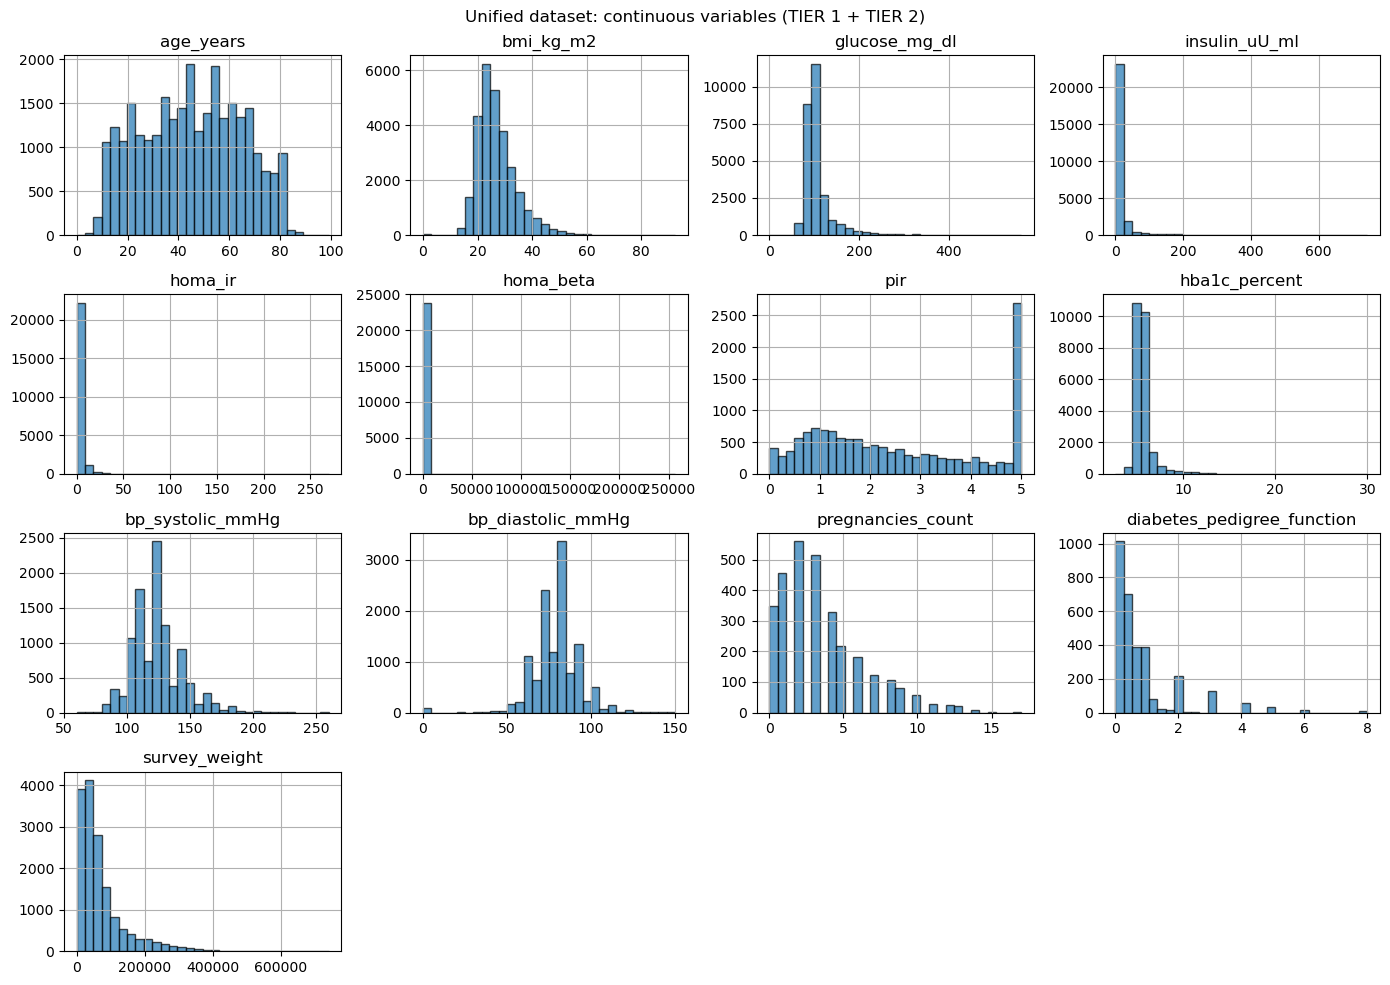

In [3]:
numeric = ['age_years', 'bmi_kg_m2', 'glucose_mg_dl', 'insulin_uU_ml', 'homa_ir', 'homa_beta', 'pir', 'hba1c_percent', 'bp_systolic_mmHg', 'bp_diastolic_mmHg', 'pregnancies_count', 'diabetes_pedigree_function', 'survey_weight']
numeric = [c for c in numeric if c in df.columns]
df[numeric].hist(figsize=(14, 10), bins=30, edgecolor='black', alpha=0.7)
plt.suptitle('Unified dataset: continuous variables (TIER 1 + TIER 2)')
plt.tight_layout()
plt.show()

## 3. Stratify by dataset_source

In [4]:
key_vars = ['age_years', 'glucose_mg_dl', 'insulin_uU_ml', 'homa_ir', 'homa_beta', 'bmi_kg_m2', 'diabetes_status']
key_vars = [c for c in key_vars if c in df.columns]
# Coerce to numeric so groupby.agg doesn't fail on pd.NA/object (e.g. from CSV)
sub = df[['dataset_source'] + key_vars].copy()
sub[key_vars] = sub[key_vars].apply(pd.to_numeric, errors='coerce')
by_source = sub.groupby('dataset_source')[key_vars].agg(['mean', 'std', 'count']).round(2)
display(by_source)

age_years              glucose_mg_dl               \
                      mean    std count          mean    std count   
dataset_source                                                       
chns_2009            47.08  18.21  9548         96.45  25.83  9498   
diabd                44.47  12.70  1065        138.45  64.83  1065   
frankfurt            33.09  11.79  2000        121.18  32.07  2000   
nhanes_2013_2014     42.91  20.79  3329        105.08  32.06  3172   
nhanes_2015_2016     43.81  20.93  3191        110.61  38.61  2972   
nhanes_2017_2020     45.13  20.73  5090        111.18  36.31  4744   
nhanes_2021_2023     48.64  20.89  3996        107.88  32.48  3672   

                 insulin_uU_ml               homa_ir  ...       homa_beta  \
                          mean     std count    mean  ... count      mean   
dataset_source                                        ...                   
chns_2009                14.55   23.39  9480    3.76  ...  9479    240.13   
diabd                     5.41    8.88  1065    7.90  ...   324    107.71   
frankfurt                80.25  111.18  2000     NaN  ...     0       NaN   
nhanes_2013_2014         13.53   18.64  3093    3.84  ...  3088    132.01   
nhanes_2015_2016         14.46   19.68  2921    4.37  ...  2919    124.91   
nhanes_2017_2020         14.98   22.85  4625    4.52  ...  4625    124.87   
nhanes_2021_2023         14.72   26.12  3510    4.34  ...  3483    127.84   

                                bmi_kg_m2             diabetes_status        \
                      std count      mean   std count            mean   std   
dataset_source                                                                
chns_2009         3036.62  9425     22.87  3.83  9324            0.09  0.29   
diabd              189.61   309     25.25  3.80  1065            0.79  0.41   
frankfurt             NaN     0     32.19  8.15  2000            0.34  0.47   
nhanes_2013_2014   163.48  3083     28.08  7.42  3291            0.12  0.32   
nhanes_2015_2016   159.86  2917     28.49  7.14  3154            0.14  0.35   
nhanes_2017_2020   212.78  4619     29.13  7.81  4985            0.15  0.36   
nhanes_2021_2023   186.47  3480     28.98  7.56  3943            0.13  0.34   

                        
                 count  
dataset_source          
chns_2009         9549  
diabd             1065  
frankfurt         2000  
nhanes_2013_2014  3329  
nhanes_2015_2016  3191  
nhanes_2017_2020  5090  
nhanes_2021_2023  3996  

[7 rows x 21 columns]

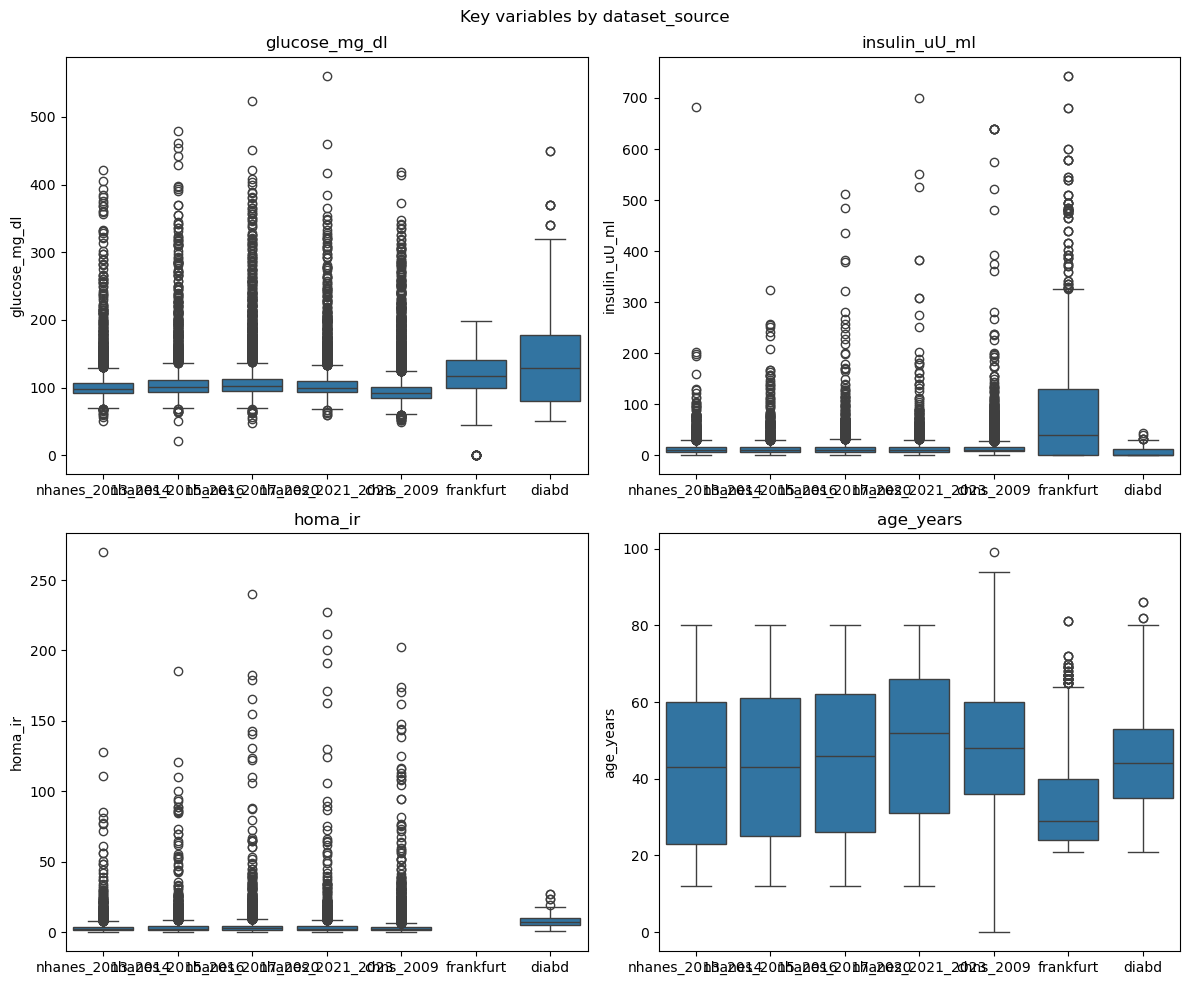

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for ax, col in zip(axes.flat, ['glucose_mg_dl', 'insulin_uU_ml', 'homa_ir', 'age_years']):
    if col not in df.columns:
        continue
    sns.boxplot(data=df, x='dataset_source', y=col, ax=ax)
    ax.set_title(col)
    ax.set_xlabel('')
plt.suptitle('Key variables by dataset_source')
plt.tight_layout()
plt.show()

## 4. Stratify by diabetes_status

In [6]:
by_diab = df.groupby('diabetes_status')[key_vars].agg(['mean', 'std', 'count']).round(2)
display(by_diab)
print('\nDiabetes prevalence by source:')
print(pd.crosstab(df['dataset_source'], df['diabetes_status'], normalize='index').round(3))

age_years               glucose_mg_dl                \
                     mean    std  count          mean    std  count   
diabetes_status                                                       
0                   43.31  19.71  23655         96.35  13.44  22575   
1                   53.74  16.04   4564        157.51  57.61   4548   

                insulin_uU_ml               homa_ir  ...        homa_beta  \
                         mean    std  count    mean  ...  count      mean   
diabetes_status                                      ...                    
0                       15.96  31.65  22215    3.05  ...  20670    178.44   
1                       34.53  69.51   4479   11.03  ...   3248    128.07   

                                bmi_kg_m2              diabetes_status       \
                     std  count      mean   std  count            mean  std   
diabetes_status                                                               
0                2057.49  20593     26.24  6.87  23274             0.0  0.0   
1                 300.09   3240     30.21  7.67   4488             1.0  0.0   

                        
                 count  
diabetes_status         
0                23656  
1                 4564  

[2 rows x 21 columns]


Diabetes prevalence by source:
diabetes_status       0      1
dataset_source                
chns_2009         0.908  0.092
diabd             0.211  0.789
frankfurt         0.658  0.342
nhanes_2013_2014  0.884  0.116
nhanes_2015_2016  0.856  0.144
nhanes_2017_2020  0.847  0.153
nhanes_2021_2023  0.867  0.133


## 5. Correlation matrix (clinical variables)

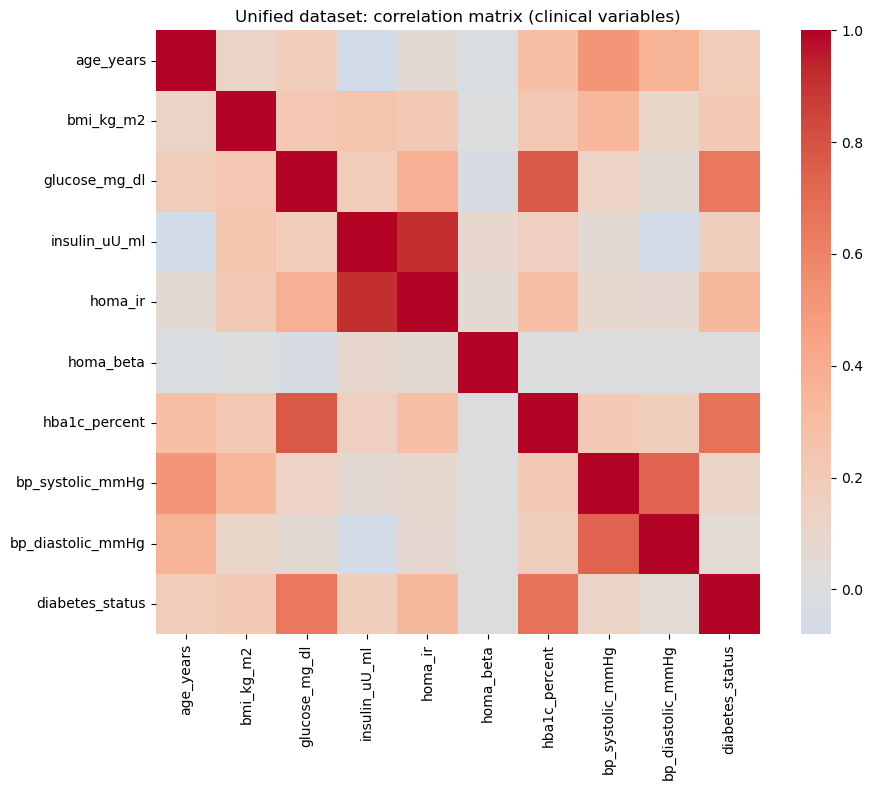

In [7]:
clinical = ['age_years', 'bmi_kg_m2', 'glucose_mg_dl', 'insulin_uU_ml', 'homa_ir', 'homa_beta', 'hba1c_percent', 'bp_systolic_mmHg', 'bp_diastolic_mmHg', 'diabetes_status']
clinical = [c for c in clinical if c in df.columns]
corr = df[clinical].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0, fmt='.2f', square=True)
plt.title('Unified dataset: correlation matrix (clinical variables)')
plt.tight_layout()
plt.show()

## 6. Missing data heatmap

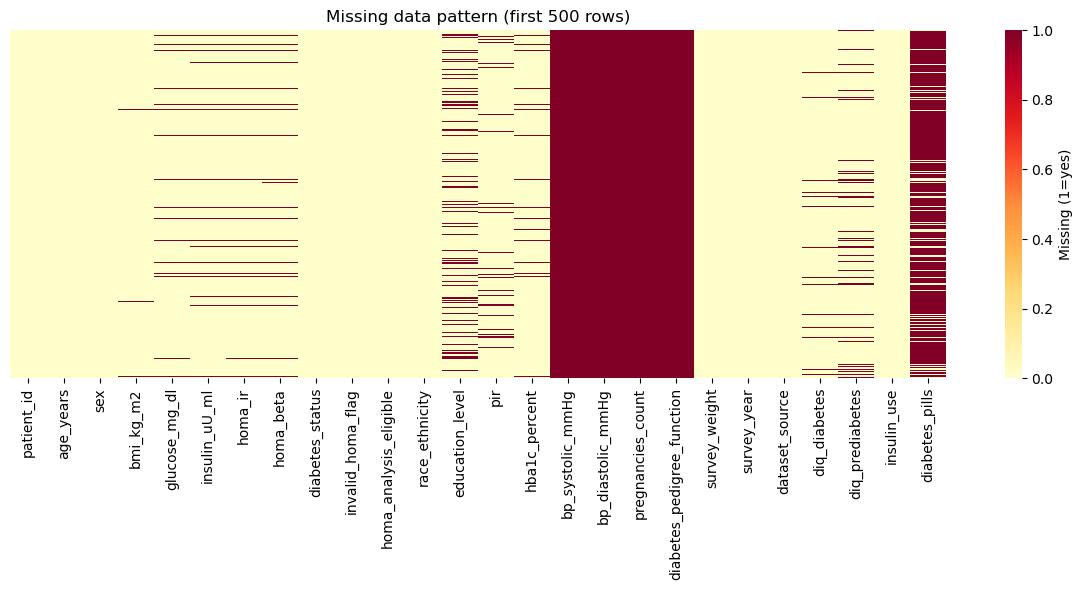


% missing per column:
patient_id                     0.0
age_years                      0.0
sex                            3.8
bmi_kg_m2                      1.6
glucose_mg_dl                  3.9
insulin_uU_ml                  5.4
homa_ir                       15.2
homa_beta                     15.5
diabetes_status                0.0
invalid_homa_flag              0.0
homa_analysis_eligible         0.0
race_ethnicity                10.9
education_level               54.1
pir                           51.1
hba1c_percent                 14.5
bp_systolic_mmHg              63.0
bp_diastolic_mmHg             56.0
pregnancies_count             89.1
diabetes_pedigree_function    89.1
survey_weight                 44.7
survey_year                   10.9
dataset_source                 0.0
diq_diabetes                  63.8
diq_prediabetes               68.1
insulin_use                   75.2
diabetes_pills                91.9


In [8]:
missing = df.isnull().astype(int)
plt.figure(figsize=(12, 6))
sns.heatmap(missing.iloc[:500], cbar_kws={'label': 'Missing (1=yes)'}, yticklabels=False, cmap='YlOrRd')
plt.title('Missing data pattern (first 500 rows)')
plt.tight_layout()
plt.show()
print('\n% missing per column:')
print((df.isnull().sum() / len(df) * 100).round(1).to_string())

## 7. Validate HOMA calculations

## 9. HOMA Analysis Eligibility (Dataset-Level Exclusions)

Beyond individual invalid samples, entire datasets are excluded from HOMA analysis:
- **Frankfurt:** 2-hour OGTT insulin (not fasting) — HOMA formulas invalid
- **DiaBD:** Data quality concerns — only 324/1065 valid, impossible skin thickness values
- **NHANES:** Gold standard fasting data — used for all HOMA modeling

**CRITICAL:** For HOMA-IR/beta prediction models, use ONLY `homa_analysis_eligible == True` samples.

In [9]:
# HOMA analysis eligibility summary
print("HOMA Analysis Eligibility by Dataset:")
print("="*60)
if 'homa_analysis_eligible' in df.columns:
    homa_eligible = df.groupby('dataset_source')['homa_analysis_eligible'].agg(['sum', 'count'])
    homa_eligible['pct'] = 100 * homa_eligible['sum'] / homa_eligible['count']
    homa_eligible.columns = ['Eligible', 'Total', '% Eligible']
    print(homa_eligible)
    homa_valid = (df.homa_analysis_eligible & ~df.invalid_homa_flag).sum()
    print(f"\nValid HOMA-eligible (for modeling): {int(homa_valid)}")
    print(f"Total samples: {len(df)}")
    print(f"Eligibility rate: {100*homa_valid/len(df):.1f}%")
    # NHANES-only HOMA-IR (eligible for analysis)
    print("\n" + "="*60)
    print("HOMA-IR Distribution: NHANES Only (Eligible for Analysis)")
    print("="*60)
    homa_eligible_data = df[df.homa_analysis_eligible & ~df.invalid_homa_flag]
    print(homa_eligible_data['homa_ir'].describe())
    print(f"\nValid HOMA-IR samples for modeling: {len(homa_eligible_data)}")
    print(f"Diabetes prevalence in HOMA-eligible: {100*homa_eligible_data.diabetes_status.mean():.1f}%")
else:
    print("Column homa_analysis_eligible not found. Rebuild unified dataset.")

HOMA Analysis Eligibility by Dataset:
                  Eligible  Total  % Eligible
dataset_source                               
chns_2009             9549   9549       100.0
diabd                    0   1065         0.0
frankfurt                0   2000         0.0
nhanes_2013_2014      3329   3329       100.0
nhanes_2015_2016      3191   3191       100.0
nhanes_2017_2020      5090   5090       100.0
nhanes_2021_2023      3996   3996       100.0

Valid HOMA-eligible (for modeling): 25085
Total samples: 28220
Eligibility rate: 88.9%

HOMA-IR Distribution: NHANES Only (Eligible for Analysis)
count    23594.000000
mean         4.083128
std          8.542666
min          0.011893
25%          1.555556
50%          2.439858
75%          4.049558
max        269.621728
Name: homa_ir, dtype: float64

Valid HOMA-IR samples for modeling: 25085
Diabetes prevalence in HOMA-eligible: 12.1%


In [10]:
# Reference: glucose 100 mg/dL, insulin 10 μU/mL → HOMA-IR = 100*10/405 ≈ 2.47, HOMA-beta = 360*10/(100-63) ≈ 97.3
passed, msg = validate_homa_reference(100.0, 10.0, expected_ir=100*10/405, expected_beta=360*10/(100-63))
print(f'Validation: {msg}')

# Spot-check on unified: pick a row with valid HOMA
valid = df['invalid_homa_flag'] == False
sub = df.loc[valid, ['glucose_mg_dl', 'insulin_uU_ml', 'homa_ir', 'homa_beta']].dropna().iloc[:1]
if len(sub) > 0:
    g, i = sub['glucose_mg_dl'].iloc[0], sub['insulin_uU_ml'].iloc[0]
    exp_ir = g * i / 405
    exp_be = 360 * i / (g - 63) if g > 63 else np.nan
    print(f'\nSample row: glucose={g}, insulin={i} → expected HOMA-IR≈{exp_ir:.2f}, HOMA-beta≈{exp_be:.2f}')
    print(f'Stored: HOMA-IR={sub["homa_ir"].iloc[0]:.2f}, HOMA-beta={sub["homa_beta"].iloc[0]:.2f}')

Validation: HOMA-IR and HOMA-beta match reference.

Sample row: glucose=193.0, insulin=5.83 → expected HOMA-IR≈2.78, HOMA-beta≈16.14
Stored: HOMA-IR=2.78, HOMA-beta=16.14


## 8. Invalid HOMA flag summary

In [11]:
print('Invalid HOMA (glucose≤0 or insulin≤0) by source:')
print(df.groupby('dataset_source')['invalid_homa_flag'].agg(['sum', 'count']).assign(pct=lambda x: (x['sum']/x['count']*100).round(1)).to_string())
print(f'\nTotal valid HOMA rows (for modeling): {(~df["invalid_homa_flag"]).sum()}')

Invalid HOMA (glucose≤0 or insulin≤0) by source:
                   sum  count    pct
dataset_source                      
chns_2009           70   9549    0.7
diabd              741   1065   69.6
frankfurt         2000   2000  100.0
nhanes_2013_2014     0   3329    0.0
nhanes_2015_2016     0   3191    0.0
nhanes_2017_2020     0   5090    0.0
nhanes_2021_2023     0   3996    0.0

Total valid HOMA rows (for modeling): 25409


## 10. CHNS 2009 - Cross-Population Validation

CHNS (China Health and Nutrition Survey) provides cross-population validation for transfer learning.

CHNS 2009 Dataset Summary:
Total samples: 9549
HOMA-eligible: 9549 (100.0%)
Valid HOMA (no missing): 9479

Demographics:
  Age: 47.1 ± 18.2 years
  Sex: Male=4539, Female=5010
  BMI: 22.87 ± 3.83 kg/m²

Biomarkers (fasting):
  Glucose: 96.4 ± 25.8 mg/dL
  Insulin: 14.55 ± 23.39 μU/mL
  HOMA-IR: 3.76 ± 7.42
  HbA1c: 5.60 ± 0.90 %

Diabetes prevalence:
  Diabetes: 882 (9.2%)
  Non-diabetes: 8667 (90.8%)

CHNS vs NHANES Comparison (HOMA-eligible samples only):
                  age_years             bmi_kg_m2           glucose_mg_dl  \
                       mean        std       mean       std          mean   
dataset_source                                                              
chns_2009         47.156679  18.141845  22.890477  3.820636     96.428896   
nhanes_2013_2014  42.913187  20.791591  28.076998  7.417122    105.084489   
nhanes_2015_2016  43.806330  20.929036  28.491408  7.136934    110.609017   
nhanes_2017_2020  45.130845  20.732948  29.130110  7.805949    111.182125   

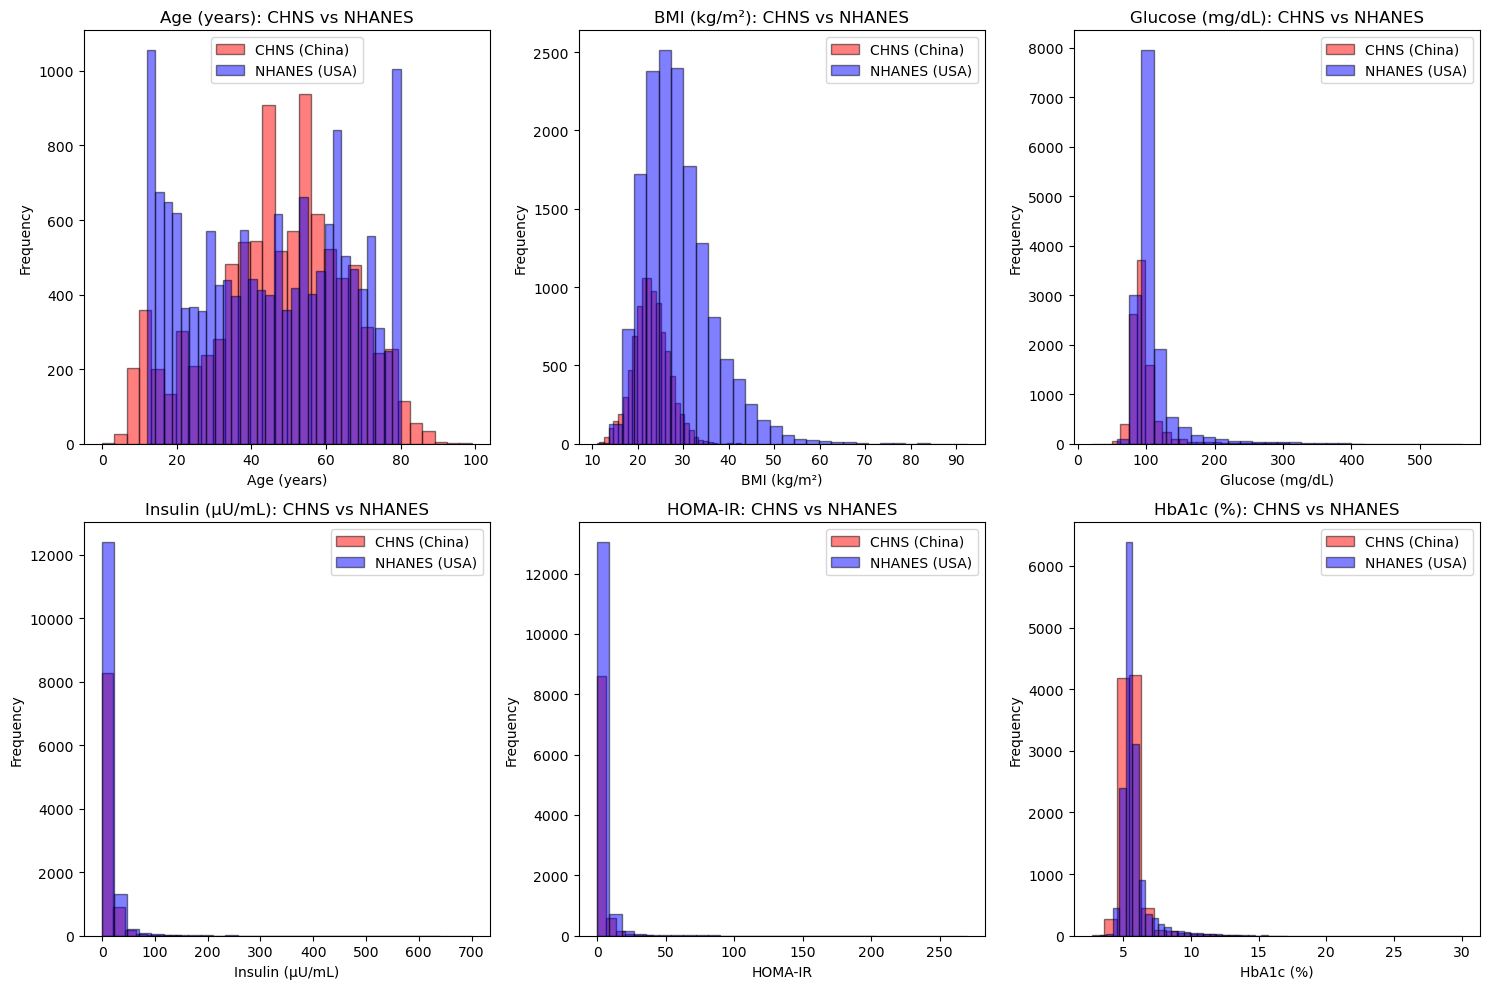

In [12]:
# CHNS-specific analysis
chns = df[df.dataset_source == 'chns_2009'].copy()

print("CHNS 2009 Dataset Summary:")
print("="*70)
print(f"Total samples: {len(chns)}")
print(f"HOMA-eligible: {chns.homa_analysis_eligible.sum()} ({100*chns.homa_analysis_eligible.mean():.1f}%)")
print(f"Valid HOMA (no missing): {(~chns.invalid_homa_flag).sum()}")

print("\nDemographics:")
print(f"  Age: {chns.age_years.mean():.1f} ± {chns.age_years.std():.1f} years")
print(f"  Sex: Male={(chns.sex == 1).sum()}, Female={(chns.sex == 0).sum()}")
print(f"  BMI: {chns.bmi_kg_m2.mean():.2f} ± {chns.bmi_kg_m2.std():.2f} kg/m²")

print("\nBiomarkers (fasting):")
print(f"  Glucose: {chns.glucose_mg_dl.mean():.1f} ± {chns.glucose_mg_dl.std():.1f} mg/dL")
print(f"  Insulin: {chns.insulin_uU_ml.mean():.2f} ± {chns.insulin_uU_ml.std():.2f} μU/mL")
print(f"  HOMA-IR: {chns[~chns.invalid_homa_flag].homa_ir.mean():.2f} ± {chns[~chns.invalid_homa_flag].homa_ir.std():.2f}")
print(f"  HbA1c: {chns.hba1c_percent.mean():.2f} ± {chns.hba1c_percent.std():.2f} %")

print("\nDiabetes prevalence:")
print(f"  Diabetes: {chns.diabetes_status.sum()} ({100*chns.diabetes_status.mean():.1f}%)")
print(f"  Non-diabetes: {(chns.diabetes_status == 0).sum()} ({100*(chns.diabetes_status == 0).mean():.1f}%)")

# Compare CHNS vs NHANES
print("\n" + "="*70)
print("CHNS vs NHANES Comparison (HOMA-eligible samples only):")
print("="*70)

homa_eligible = df[df.homa_analysis_eligible & ~df.invalid_homa_flag].copy()
comparison = homa_eligible.groupby('dataset_source').agg({
    'age_years': ['mean', 'std'],
    'bmi_kg_m2': ['mean', 'std'],
    'glucose_mg_dl': ['mean', 'std'],
    'insulin_uU_ml': ['mean', 'std'],
    'homa_ir': ['mean', 'std'],
    'diabetes_status': 'mean'
})
print(comparison)

# Visualize distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
variables = ['age_years', 'bmi_kg_m2', 'glucose_mg_dl', 'insulin_uU_ml', 'homa_ir', 'hba1c_percent']
titles = ['Age (years)', 'BMI (kg/m²)', 'Glucose (mg/dL)', 'Insulin (μU/mL)', 'HOMA-IR', 'HbA1c (%)']
for idx, (var, title) in enumerate(zip(variables, titles)):
    ax = axes[idx // 3, idx % 3]
    chns_data = chns[chns[var].notna()][var]
    ax.hist(chns_data, bins=30, alpha=0.5, label='CHNS (China)', color='red', edgecolor='black')
    nhanes_data = df[df.dataset_source.str.startswith('nhanes') & df[var].notna()][var]
    ax.hist(nhanes_data, bins=30, alpha=0.5, label='NHANES (USA)', color='blue', edgecolor='black')
    ax.set_xlabel(title)
    ax.set_ylabel('Frequency')
    ax.legend()
    ax.set_title(f'{title}: CHNS vs NHANES')
plt.tight_layout()
out_path = Path('../reports/chns_vs_nhanes_comparison.png')
out_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(out_path, dpi=150, bbox_inches='tight')
print(f"\n✅ Saved: {out_path}")
plt.show()